In [10]:
# from utils import box_iou
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageDraw2
from retinanet.encoder import DataEncoder
from retinanet.retinanet import RetinaNet

from retinanet.fpn import FPN50
from torch import Tensor as T
import torch 
import imgaug as ia
from retinanet.utils import change_box_order, box_iou
import matplotlib.pyplot as plt
from torch import Tensor as T
from torch.autograd import Variable as V
%matplotlib inline
import pandas as pd
from torchsummary import summary
from retinanet.retinanet import RetinaNet
from retinanet.fpn import *
from torch import nn

def calc_area(box):
    w = np.abs(box[2] - box[0]) #xmin ymin xxmax ymax
    h = np.abs(box[3] - box[1])

    return w * h 

im_size = (750,750)



In [23]:
!pip freeze 

imgaug==0.2.5


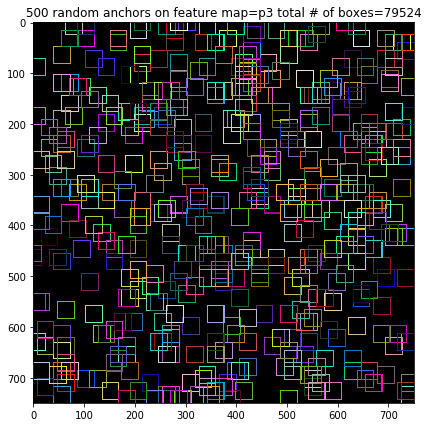

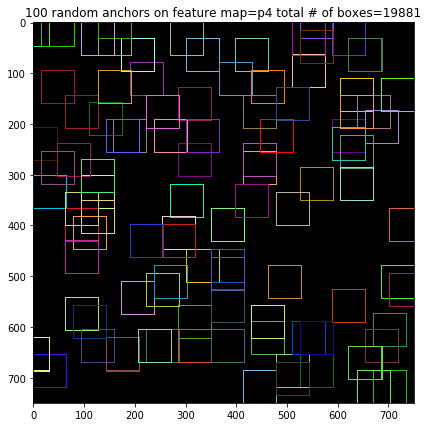

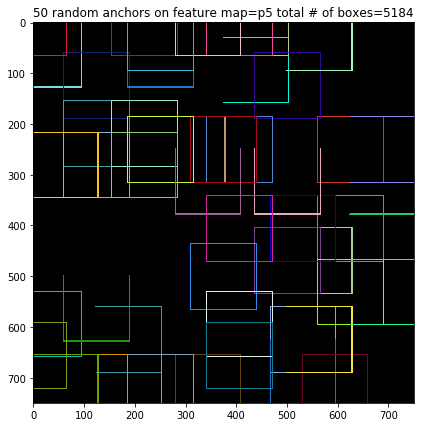

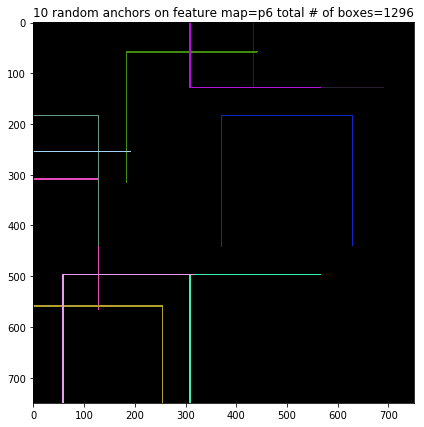

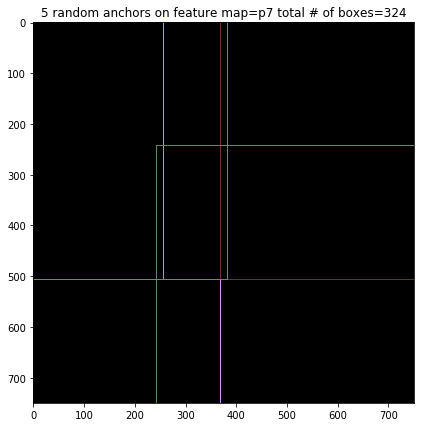

In [13]:
encoder = DataEncoder()
encoder.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512 * 512.]  # p3 -> p7
encoder.aspect_ratios = [1, 1. , 1]
encoder.scale_ratios = [1,1,1]

# encoder.aspect_ratios = [1,1,1]
# encoder.scale_ratios = [1,1]
encoder.anchor_wh = encoder._get_anchor_wh()

anchors, anchors_per_fm = encoder._get_anchor_boxes(T(im_size))
anchors = change_box_order(anchors, 'xywh2xyxy')


feature_map_names = ['p3', 'p4', 'p5', 'p6', 'p7']
n_anchors = [500,100,50,10,5]
for fm_name, boxes, i in zip(feature_map_names, anchors_per_fm, n_anchors):
    number_of_anchors_total = len(boxes)
    anch = np.array(change_box_order(boxes, 'xywh2xyxy'))
    rnd_ix = np.random.randint(0, len(anch), i)
    rnd_anchors = np.array(anch[rnd_ix, :])
    canvas = Image.fromarray(np.uint8(np.zeros(im_size + (3,))))
    bbs = [ia.BoundingBox(*b) for b in rnd_anchors]
    for box in bbs:
        canvas = box.draw_on_image(
            canvas, color=np.random.rand(3) * 255, thickness=2, 
        )  
        
    plt.figure(figsize=(7,7))
    plt.title("{} random anchors on feature map={} total # of boxes={}".format(i, fm_name, number_of_anchors_total))
    plt.imshow(canvas)
    plt.grid(False)



In [17]:
# loc_targets, cls_targets = encoder.encode(some_box, labels, input_size)
# print(loc_targets.shape)
# print(cls_targets.shape)
# sum(cls_targets>0)

tensor([[  -7.0711,  -14.1421,    7.0711,   14.1421],
        [  -8.9090,  -17.8180,    8.9090,   17.8180],
        [ -11.2246,  -22.4492,   11.2246,   22.4492],
        ...,
        [ 262.9613,  443.9807,  987.0387,  806.0193],
        [ 168.8599,  396.9299, 1081.1401,  853.0701],
        [  50.2994,  337.6497, 1199.7006,  912.3503]])
(92, 4)


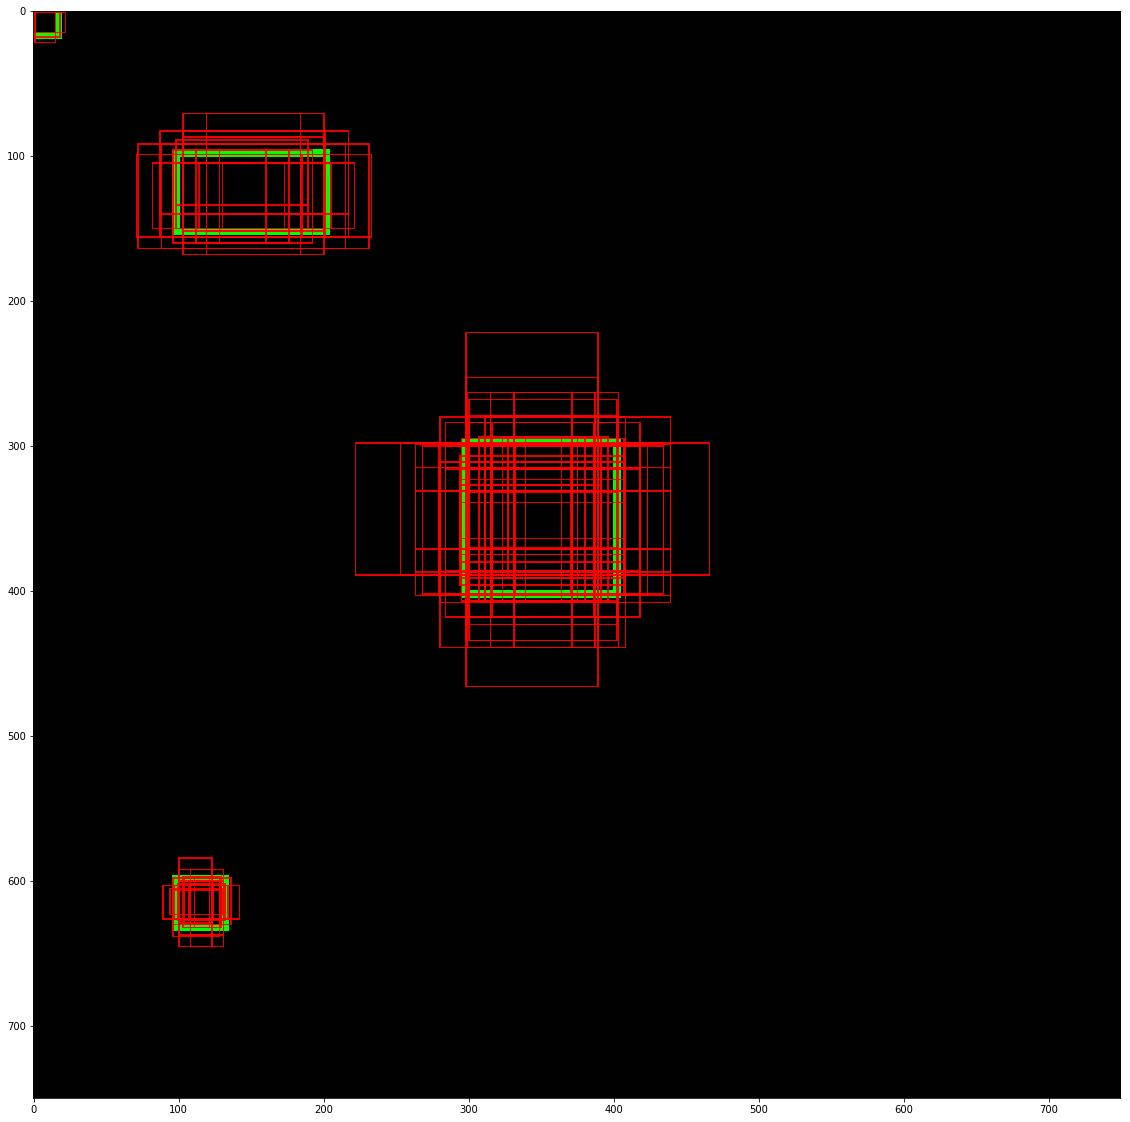

In [18]:
encoder = DataEncoder(anchor_areas=[20*20., 64*64., 128*128., 256*256., 512*512.])
# encoder.anchor_areas = [15*15, 64*64., 128*128., 256*256., 512*512.]
anchors,_ = encoder._get_anchor_boxes(T(im_size))

anchors = change_box_order(anchors, 'xywh2xyxy')
print(anchors)
anchors = np.array(anchors)
some_box = T([[0,0,15,15], [100,100,200,150],[300,300,400,400], [100,600, 130, 630]])
input_size = T(im_size)
labels = T([0,1,2,3])
loc_targets, cls_targets = encoder.encode(some_box, labels, input_size)


matched_anchors = anchors[np.array(cls_targets>0.9).astype(bool),:]


real_bbs_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in some_box], shape=im_size)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in matched_anchors], shape=im_size)

print(matched_anchors.shape)

canvas = np.ones(im_size+(3,))
image = Image.fromarray(np.uint8(canvas))
image = real_bbs_on_image.draw_on_image(image, thickness=5)
image = matched_anchors_on_image.draw_on_image(image, color=[255,0,0], thickness=1, alpha=0.9)

plt.figure(figsize=(20,20))
plt.imshow(image)


In [ ]:
# from utils import box_iou
# a = T([[0,0,30,30]])
# b = T([36, 76, 35, 71])
box_iou(T(matched_anchors), T([[428,516,32,32]]))

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

bb_intersection_over_union([0,0,30,30], [36, 76, 35, 71])

In [ ]:
de = DataEncoder()
a, boxes = de._get_anchor_boxes(T([600,600]))
change_box_order(boxes[4], 'xywh2xyxy')

In [20]:
from PIL import Image
import numpy as np 
import imgaug as ia
import matplotlib.pyplot as plt


image_orig = np.array(Image.open('static/example_image.jpg'))
boxes_orig = np.array(
    [[  40.,  459.,   80.,  499.],
    [ 344.,  103.,  384.,  143.],
    [ 509.,  439.,  549.,  479.],
    [ 178.,   80.,  218.,  120.],
    [ 710.,   -6.,  750.,   33.],
    [ 235.,  541.,  275.,  581.],
    [ 598.,   45.,  638.,   85.],
    [ 547.,  256.,  587.,  296.],
    [  63.,  245.,  103.,  286.],
    [ 257.,  102.,  297.,  142.],
    [ 164.,  320.,  204.,  360.],
    [ 713.,  563.,  753.,  603.],
    [ 605.,  327.,  645.,  367.]], dtype=np.float32)


bbs_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*box) for box in boxes_orig], shape=image.shape
)


[598.0, 45.0, 638.0, 85.0]

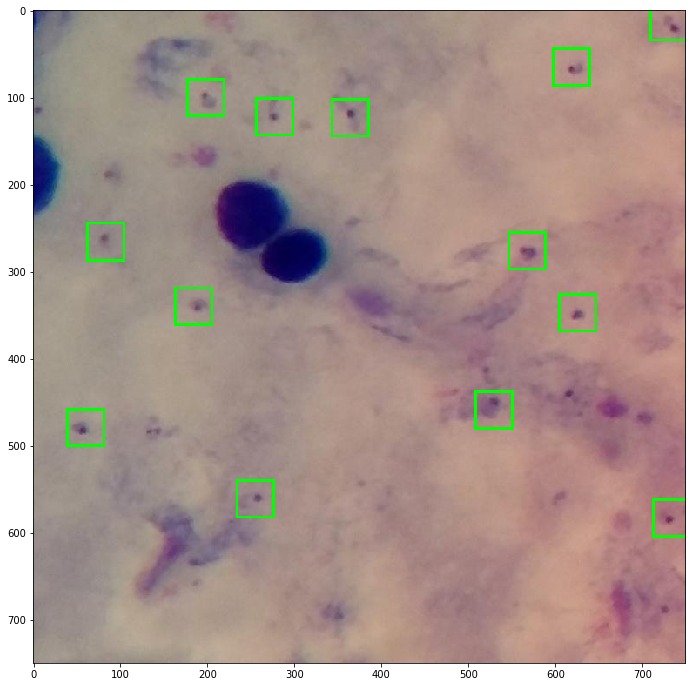

In [21]:
plt.figure(figsize=(12,12))
plt.imshow(bbs_on_image.draw_on_image(image_orig, thickness=3))

[ 598.,   45.,  638.,   85.]

In [7]:
encoder = DataEncoder()
encoder.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512 * 512.]  # p3 -> p7
encoder.aspect_ratios = [1.]#[0.5, 1. , 2.]
encoder.scale_ratios = [1.] #[0.5, 1., 2.]

# encoder.aspect_ratios = [1,1,1]
# encoder.scale_ratios = [1,1]
encoder.anchor_wh = encoder._get_anchor_wh()

anchors, anchors_per_fm = encoder._get_anchor_boxes(T(im_size))
anchors = change_box_order(anchors, 'xywh2xyxy')

feature_map_names = ['p3', 'p4', 'p5', 'p6', 'p7']
n_anchors = [500,100,50,10,5]
ibox = 0
plt.figure(figsize=(15,15))

for fm_name, boxes, i in zip(feature_map_names, anchors_per_fm, n_anchors):
    number_of_anchors_total = len(boxes)
    anch = np.array(change_box_order(boxes, 'xywh2xyxy'))
    rnd_ix = np.random.randint(0, len(anch), i)
    rnd_anchors = np.array(anch[rnd_ix, :])
    canvas = image_orig
    bbs = [ia.BoundingBox(*b) for b in rnd_anchors]
    for box in bbs:
        canvas = box.draw_on_image(
            canvas, color=np.random.rand(3) * 255, thickness=4, 
        )  
    print(ibox)
    plt.subplot(3,3,ibox+1)
    plt.title("Anchors on f-map={} # of boxes={}".format(fm_name, number_of_anchors_total))
    plt.imshow(canvas)
    ibox+=1
    

RuntimeError: shape '[1, 1, 9, 2]' is invalid for input of size 2

In [25]:
input_size =  torch.Tensor([100,100])
fm_sizes = [(input_size/pow(2.,i+3)).ceil() for i in range(5)]  #
print("9 are all the combinations of scales and aspect ratios for each box")
for s in fm_sizes:
    s = s[0]
    print("{} * {} * 9 = {}".format(s,s,s*s*9))

9 are all the combinations of scales and aspect ratios for each box
13.0 * 13.0 * 9 = 1521.0
7.0 * 7.0 * 9 = 441.0
4.0 * 4.0 * 9 = 144.0
2.0 * 2.0 * 9 = 36.0
1.0 * 1.0 * 9 = 9.0


tensor([[ -11.3137,  -22.6274,   11.3137,   22.6274],
        [ -14.2544,  -28.5088,   14.2544,   28.5088],
        [ -17.9594,  -35.9188,   17.9594,   35.9188],
        ...,
        [ 262.9613,  443.9807,  987.0387,  806.0193],
        [ 168.8599,  396.9299, 1081.1401,  853.0701],
        [  50.2994,  337.6497, 1199.7006,  912.3503]])
(536, 4)


Text(0.5,1,'Ground truth objects (green) and anchor boxes red with IoU>0.5')

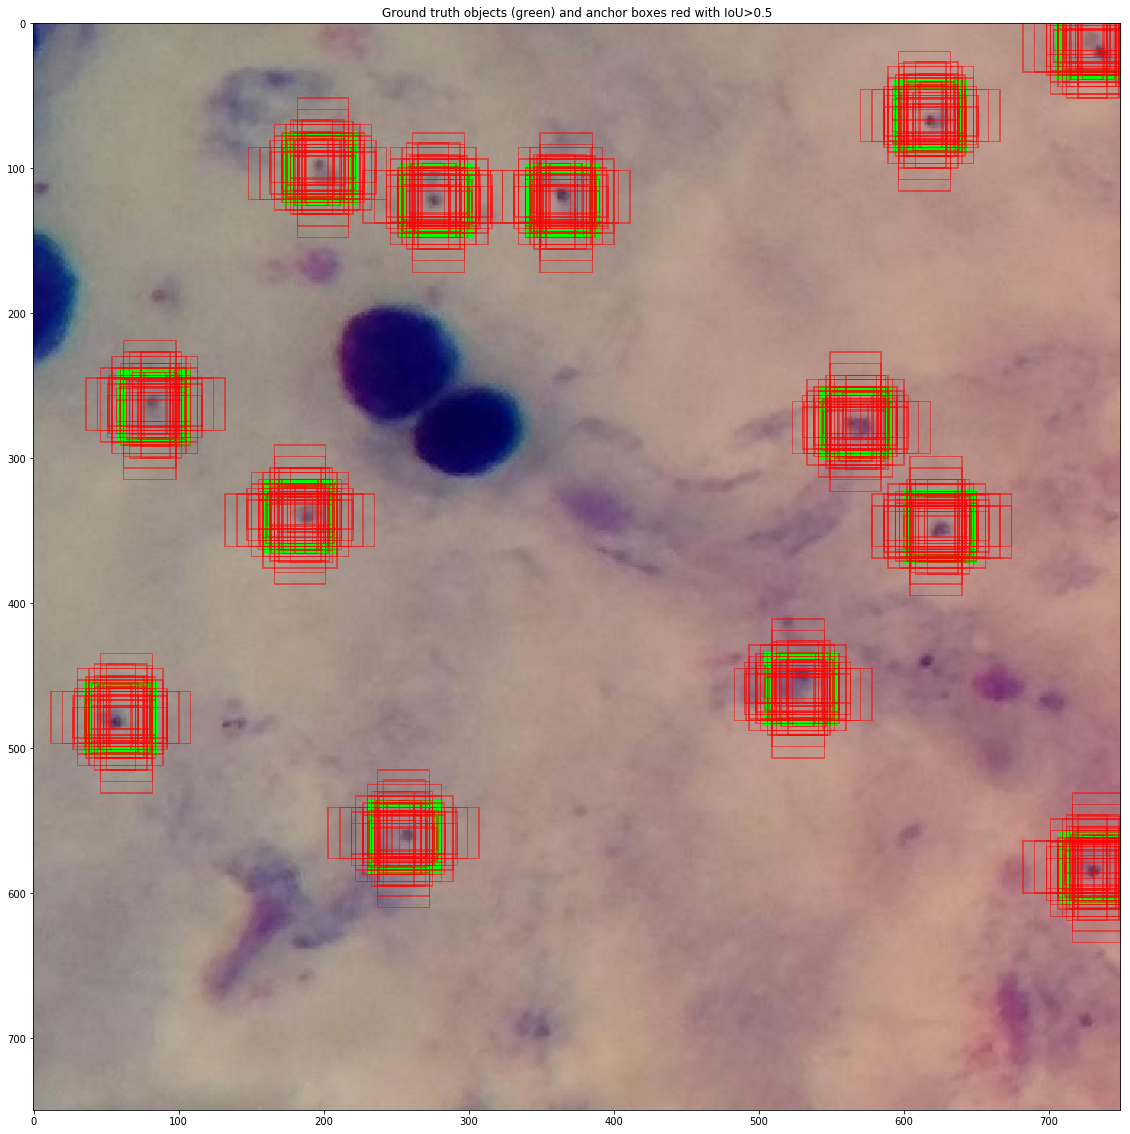

In [37]:
encoder = DataEncoder()
anchors,_ = encoder._get_anchor_boxes(T(im_size))
anchors = change_box_order(anchors, 'xywh2xyxy')
print(anchors)
anchors = T(np.array(anchors))
some_box = T(boxes_orig[:])
input_size = T(im_size)
labels = T([0] * len(some_box))
loc_targets, cls_targets = encoder.encode(some_box, labels, input_size)


matched_anchors = np.array(anchors)[np.array(cls_targets>0.9).astype(bool),:]


real_bbs_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in some_box], shape=im_size)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in matched_anchors], shape=im_size)

print(matched_anchors.shape)

canvas = image_orig
image = Image.fromarray(np.uint8(canvas))
image = real_bbs_on_image.draw_on_image(image, thickness=6)
image = matched_anchors_on_image.draw_on_image(image, color=[255,0,0], thickness=1, alpha=0.5)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.title("Ground truth objects (green) and anchor boxes red with IoU>0.5")

                     0       iou
anchor1  ground_truth1  0.780488
anchor2  ground_truth2  0.513689
anchor3  ground_truth3  0.627451
anchor4  ground_truth1  0.000000
anchor5  ground_truth1  0.000000


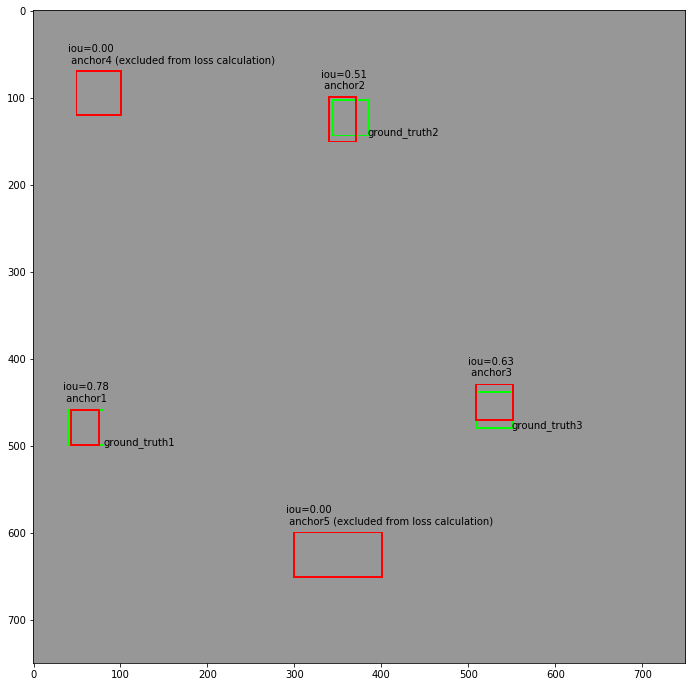

In [36]:
from matplotlib.pyplot import text

bx = np.array(
    [[40., 459., 80., 499.],
     [344., 103., 384., 143.],
     [509., 439., 549., 479.]])

anch = np.array(
    [[44, 459, 75, 499],
     [340, 100, 370, 150],
     [509, 430, 550, 470],
     [50, 70, 100, 120],
     [300, 600, 400, 650]
     ])

canvas = Image.fromarray(np.uint8(np.ones(im_size + (3,)) + (150,150,150)))

bx_to_draw = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*box) for box in bx], shape=image.shape
)

anch_to_draw =  ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*box) for box in anch], shape=image.shape
)

canvas = bx_to_draw.draw_on_image(canvas, thickness=2)
canvas = anch_to_draw.draw_on_image(canvas, thickness=2, color=[255,0,0])

plt.figure(figsize=(12,12))
plt.imshow(canvas)

io = box_iou(T(anch), T(bx))
maxes,ids = io.max(1)


for i, a in enumerate(bx):
    m = 'ground_truth{0}'.format(i+1)
    text(a[2], a[3],str(m))
    

for i, (a,m) in enumerate(zip(anch, maxes)):
    m = 'iou={0:.2f}\n anchor{1}'.format(m,i+1)
    if i == 3 or i == 4:
        m +=  ' (excluded from loss calculation)'

    text(a[0]-10, a[1]-10,str(m))
        
    

plt.draw()
    
df = pd.DataFrame((io.numpy()))
df.index = ['anchor1', 'anchor2','anchor3', 'anchor4', 'anchor5']
df.columns  =['ground_truth1','ground_truth2', 'ground_truth3']
d = pd.DataFrame(df.idxmax(axis=1))
d['iou'] = df.max(axis=1)
print(d)
ids = df.idxmax(axis=1)

In [34]:
def smooth_l1(x):
    if abs(x) < 1:
        return 0.5 * (x ** 2)
    else:
        return abs(x) - 0.5
    
def l2(x):
    return x**2

def l1(x):
    return abs(x)

def wing_loss(w, e, x):
    if abs(x) < w:
        return w * np.log(1 + abs(x)/e)
    else:
        return w - np.log(1 + w) / e

Text(0,0.5,'loss')

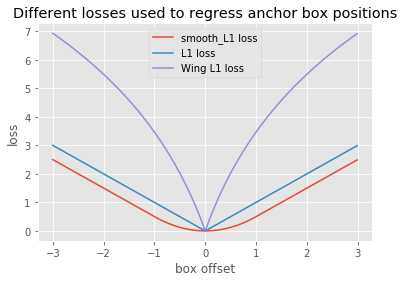

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = np.arange(-3, 3, 0.01)
y = np.array([smooth_l1(xha) for xha in x])
plt.plot(x, y)

x = np.arange(-3, 3, 0.01)
y = np.array([l1(xha) for xha in x])

plt.plot(x,y)

x = np.arange(-3, 3, 0.01)
y = np.array([wing_loss(w=5, e=1, x=xha) for xha in x])
plt.plot(x,y)
plt.title("Different losses used to regress anchor box positions")
plt.legend(['smooth_L1 loss', 'L1 loss', 'Wing L1 loss'])
plt.xlabel('box offset')
plt.ylabel('loss')

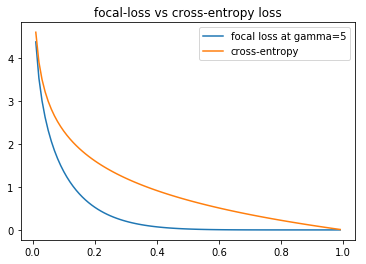

In [30]:
def CE_loss(pt):
    return -np.log(pt)

def FL_loss(pt, gamma):
    return -(1-pt)**gamma * np.log(pt)

p = np.arange(0.01, 1, 0.01)

plt.plot(p, FL_loss(p, gamma=5))
# plt.plot(p, FL_loss(p, gamma=1))
# plt.plot(p, FL_loss(p, gamma=5))
plt.plot(p, CE_loss(p))
plt.title('focal-loss vs cross-entropy loss')
plt.legend(['focal loss at gamma=5', 'cross-entropy'])

